🍁 Preprocessing

In [12]:
from keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np

# Import
(x_train, y_train), (_, _) = mnist.load_data()
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

# 1. Flatten
x_train_flat = x_train.reshape(x_train.shape[0], -1)
print(f"x_train_flat shape: {x_train_flat.shape}, y_train shape: {y_train.shape}")

# 2. Subsets
subset_size = 1000
x_train_subset = x_train_flat[:subset_size]
y_train_subset = y_train[:subset_size]
print(f"x_train_subset shape: {x_train_subset.shape}")

# 3. PCA
n_components = 77  # Reduce to 77 components
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_subset)
print(f"x_train_pca shape: {x_train_pca.shape}")
variance = np.sum(pca.explained_variance_ratio_)
print(f"variance = {variance}")  # Verify how much variance is retained

# 4. Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_norm = scaler.fit_transform(x_train_pca)
print(f"x_train_norm shape: {x_train_norm.shape}")

x_train shape: (60000, 28, 28), y_train shape: (60000,)
x_train_flat shape: (60000, 784), y_train shape: (60000,)
x_train_subset shape: (1000, 784)
x_train_pca shape: (1000, 77)
variance = 0.9022549810637561
x_train_norm shape: (1000, 77)


🍁 Check Directory

In [13]:
import os

# Path to your existing directory
models_dir = "/home/ajayp/RClass/models/"
print(f"Using existing directory: {models_dir}")

# Check if the directory exists
if os.path.exists(models_dir):
    print("Directory already exists.")
else:
    print("Directory does not exist!")

Using existing directory: /home/ajayp/RClass/models/
Directory already exists.


🍁 Problem Setup & Variable Initialization

In [14]:
from sage.numerical.mip import MixedIntegerLinearProgram

# 1. Initialize the problem (Minimization problem)
p = MixedIntegerLinearProgram(maximization=False, solver="GLPK")

# 3. Define coefficients
num_coefficients = 77  # PCA components
# num_coefficients = len(multi_indices)

# 2. Create variables
vars = p.new_variable(real=True)  # Real-valued variables
theta = vars["theta"]  # θ - error bound to minimize
alpha = [vars[f"a{j}"] for j in range(num_coefficients)]  # α coefficients
beta = [vars[f"b{j}"] for j in range(num_coefficients)]   # β coefficients


🍁 Simple Approach: Construct G(x) & H(x) Matrices

In [15]:
# import numpy as np

# def construct_G_H_matrices(x_train_norm, n_components):

#     # Parameters
#     num_data_points = x_train_norm.shape[0]
#     num_coefficients = n_components + 1  # Include constant terms α0 & β0

#     # Initialize G and H matrices
#     G = np.zeros((num_data_points, num_coefficients))  # Numerator
#     H = np.zeros((num_data_points, num_coefficients))  # Denominator

#     # Construct G and H matrices
#     for i in range(num_data_points):
#         G[i, 0] = 1  # Constant term for numerator
#         H[i, 0] = 1  # Constant term for denominator
#         for j in range(num_coefficients - 1):
#             G[i, j+1] = x_train_norm[i, j] ** (j+1)  # Polynomial terms
#             H[i, j+1] = x_train_norm[i, j] ** (j+1)

#     return G, H

🍁 Multi-Indices Generation (Polynomials)

In [16]:
import itertools

def generate_multi_indices(n, d):
    return [idx for idx in itertools.product(range(d + 1), repeat=n) if sum(idx) <= d]

multi_indices = generate_multi_indices(2, 2)
print(f"Multi-indices: {multi_indices}")

🍁 Construct G(x) and H(x) Matrices

In [17]:
def construct_G_H_matrices(x_train_norm, n, d):
    num_data_points = x_train_norm.shape[0]
    multi_indices = generate_multi_indices(n, d)
    num_coefficients = len(multi_indices)

    # Initialize G and H matrices
    G = []
    H = []

    # Construct G and H using multi-indices
    for i in range(num_data_points):
        G_row = []
        H_row = []
        for idx in multi_indices:
            term = np.prod([x_train_norm[i, k] ** idx[k] for k in range(n)])
            G_row.append(term)
            H_row.append(term)
        G.append(G_row)
        H.append(H_row)
    
    return G, H, multi_indices

🍁 Feasibility Check

In [18]:
from sage.numerical.mip import MixedIntegerLinearProgram
import numpy as np

def check_feasibility_and_compute_coefficients(z, x_train_norm, y_binary, n_components):
    # Parameters
    num_data_points = x_train_norm.shape[0]
    num_coefficients = n_components + 1
    delta = 1e-6  # Avoid zero denominator

    # Construct G and H matrices
    # Approach 1
    G, H = construct_G_H_matrices(x_train_norm, n_components)

    # Approach 2
    # G, H, _ = construct_G_H_matrices(x_train_norm, 2, 2)

    # Define constraints and optimization
    p = MixedIntegerLinearProgram(maximization=False)
    vars = p.new_variable(real=True)

    # Variables
    theta = vars["theta"]
    alpha = [vars[f"a{j}"] for j in range(num_coefficients)]
    beta = [vars[f"b{j}"] for j in range(num_coefficients)]

    # Add Constraints
    for i in range(num_data_points):
        # Upper Bound Constraint
        f_minus_z = y_binary[i] - z
        p.add_constraint(
            -sum(alpha[j] * G[i][j] for j in range(num_coefficients)) +
            f_minus_z * sum(beta[j] * H[i][j] for j in range(num_coefficients)) -
            theta <= 0
        )
        # Lower Bound Constraint
        f_plus_z = y_binary[i] + z
        p.add_constraint(
            sum(alpha[j] * G[i][j] for j in range(num_coefficients)) -
            f_plus_z * sum(beta[j] * H[i][j] for j in range(num_coefficients)) -
            theta <= 0
        )
        # Positivity Constraint for β
        p.add_constraint(
            sum(beta[j] * H[i][j] for j in range(num_coefficients)) >= delta
        )

    # Objective: Minimize θ
    p.set_objective(theta)

    # Solve the problem
    try:
        p.solve()
        optimal_alpha = [p.get_values(alpha[j]) for j in range(num_coefficients)]
        optimal_beta = [p.get_values(beta[j]) for j in range(num_coefficients)]
        optimal_theta = p.get_values(theta)
        return True, optimal_alpha, optimal_beta, optimal_theta
    except Exception as e:
        return False, None, None, None

🍁 Bisection Loop

In [19]:
def bisection_loop(x_train_norm, y_binary, uL, uH, precision, n_components):
    optimal_alpha, optimal_beta, optimal_theta = None, None, None
    z_values = []

    while uH - uL > precision:
        z = (uL + uH) / 2
        z_values.append(z)

        # Feasibility Check
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility_and_compute_coefficients(
            z, x_train_norm, y_binary, n_components
        )

        # Update bounds based on feasibility
        if feasible:
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            uL = z

    return uH, optimal_alpha, optimal_beta, optimal_theta, z_values

🍁 Training for Each Digit

In [21]:
import pickle

for digit in range(10):
    print(f"Training classifier for digit {digit}...")

    # Binary labels for one-vs-all classification
    y_binary = (y_train_subset == digit).astype(float)

    # Scale binary labels (2-Y, 4-N)
    y_binary = np.where(y_binary == 1, 2, 4)

    # Bisection parameters
    uL = 0  # Lower bound
    uH = 500  # Upper bound
    precision = 1e-6  # Precision threshold

    # Bisection loop
    optimal_z, optimal_alpha, optimal_beta, optimal_theta, z_values = bisection_loop(
        x_train_norm, y_binary, uL, uH, precision, n_components
    )

    # Results
    print(f"Digit {digit}: Optimal z = {optimal_z}")
    print(f"Alpha: {optimal_alpha}")
    print(f"Beta: {optimal_beta}")
    print(f"Theta: {optimal_theta}")

    # Save the model
    model = {
        "alpha": optimal_alpha,
        "beta": optimal_beta,
        "theta": optimal_theta,
        "n_components": n_components
    }
    with open(f"{models_dir}/classifier_{digit}.pkl", "wb") as file:
        pickle.dump(model, file)

    print(f"Model saved for digit {digit} at {models_dir}")

Training classifier for digit 0...
Digit 0: Optimal z = 22282498125/67108864
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009325441277321631, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Beta: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14557688690032647, 0.0, -2.8256322357636923, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -6.00179772023484, 0.0, 0.0, 0.0, 126.00190564179435, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10021.26520430418, 0.0, 0.0, 0.0, 0.0, 0.0, 122881.59385468383, 0.0, 0.0, 0.0, 0.0, 383737.36713365436, 490957291391.57916, 0.0, 0.0, 0.0, 0.0, -3076976.95976099, 0.0, 0.0, 0.0, 1.2851673707041699e+31, 0.0, 0.0005712671208861209, 0.0, -90.26442

🍁 Testing

x_test shape: (10000, 28, 28), y_test shape: (10000,)
x_test shape: (10000, 784), y_test shape: (10000,)
x_test_subset shape: (10000, 784)
x_test_pca shape: (10000, 77)
x_test_norm shape: (10000, 77)
Accuracy for digit 0: 9.80%
Accuracy for digit 1: 11.35%
Accuracy for digit 2: 10.32%
Accuracy for digit 3: 10.10%
Accuracy for digit 4: 9.82%
Accuracy for digit 5: 12.02%
Accuracy for digit 6: 9.58%
Accuracy for digit 7: 10.28%
Accuracy for digit 8: 11.14%
Accuracy for digit 9: 10.09%
Overall Accuracy: 10.45%


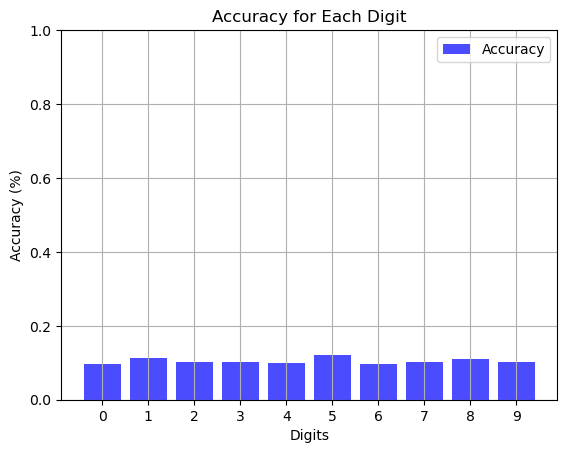

In [22]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import pickle
import matplotlib.pyplot as plt
from keras.datasets import mnist
import os

#-----------------------------------------------------
# Simple Approach
# Define rational function for polynomial approach
def rational_function(x, alpha, beta):
    numerator = alpha[0] + sum(alpha[i+1] * x[i] ** (i + 1) for i in range(len(x)))
    denominator = beta[0] + sum(beta[i+1] * x[i] ** (i + 1) for i in range(len(x)))

    # Avoid division by zero
    if abs(denominator) < 1e-8:
        denominator = 1e-8

    return numerator / denominator

#-----------------------------------------------------
#2 Multi-Indices Approach
# import itertools

# def generate_multi_indices(n, d):
#     indices = [idx for idx in itertools.product(range(d + 1), repeat=n) if sum(idx) <= d]
#     return indices

# def construct_polynomial(x, coefficients, indices):
#     polynomial_value = 0
#     for coeff, idx in zip(coefficients, indices):
#         term = coeff * np.prod([x[i] ** idx[i] for i in range(len(x))])
#         polynomial_value += term
#     return polynomial_value

# def rational_function(x, alpha, beta, n, d):
#     indices = generate_multi_indices(n, d)

#     # Compute numerator and denominator
#     numerator = construct_polynomial(x, alpha, indices)
#     denominator = construct_polynomial(x, beta, indices)

#     # Avoid division by zero
#     if abs(denominator) < 1e-8:
#         denominator = 1e-8

#     return numerator / denominator

#-----------------------------------------------------
# Import and Preprocess Test Data
(_, _), (x_test, y_test) = mnist.load_data()
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Flatten
x_test = x_test.reshape(x_test.shape[0], -1)
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Subsets
subset_size = 10000
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]
print(f"x_test_subset shape: {x_test_subset.shape}")

# PCA
n_components = 77
pca = PCA(n_components=n_components)
x_test_pca = pca.fit_transform(x_test_subset)
print(f"x_test_pca shape: {x_test_pca.shape}")

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
x_test_norm = scaler.fit_transform(x_test_pca)
print(f"x_test_norm shape: {x_test_norm.shape}")

#-----------------------------------------------------
# Directory Setup for Models (SageMath Path)
models_dir = "/home/ajayp/RClass/models/"
if not os.path.exists(models_dir):
    raise FileNotFoundError(f"Models directory not found at: {models_dir}")

accuracies = []

#-----------------------------------------------------
# Load Saved Models and Test
for digit in range(10):
    
    # Load the model for each digit
    with open(f"{models_dir}/classifier_{digit}.pkl", "rb") as file:
        model = pickle.load(file)

    alpha = model["alpha"]
    beta = model["beta"]
    theta = model["theta"]

    # Evaluate predictions using Polynomial Approach
    y_predicted = [
        rational_function(x, alpha, beta) for x in x_test_norm
    ]

    # Evaluate predictions using Multi-Indices Approach
    # n = 2
    # d = 2
    # y_predicted = [
    #     rational_function(x, alpha, beta, n, d) for x in x_test_norm
    # ]

    # Binary classification based on predictions
    y_pred_binary = np.array(y_predicted) < 3
    y_true_binary = y_test_subset == digit

    # Compute accuracy
    accuracy = np.mean(y_pred_binary == y_true_binary)
    accuracies.append(accuracy)
    print(f"Accuracy for digit {digit}: {accuracy * 100:.2f}%")


#-----------------------------------------------------
# Overall Accuracy
overall_accuracy = np.mean(accuracies)
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

#-----------------------------------------------------
# Plot Accuracies for Each Digit
plt.bar(range(10), accuracies, color='blue', alpha=0.7, label="Accuracy")
plt.xlabel("Digits")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy for Each Digit")
plt.xticks(range(10))
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()